# Kvantuminformatika és -kommunikáció

## Kvantuminformatikai algoritmusok tervezése gyakorlat
### Általános tudnivalók

Ezen a gyakorlaton a kvantumalgoritumsok tervezésével és tesztelésével fogunk foglalkozni. Ehhez a [Qiskit](https://qiskit.org/) python-os könyvtárat és a [Jupyter Notebook](https://jupyter.org/)-ot fogjuk használni.

A gyakorlat elvégézéshez szükséges a Python programozási nyelv ismerete, de ha valaki esetleg még nem használta, azzal sincsen semmi probléma. A feladatok megoldásához szükséges lépéseket közösen át fogjuk beszélni.

Ha valaki saját gépen szeretné elvégezni a mérést, akkor fel kell telepíteni egy Python-t, a Jupyter-t és a Qiskit-et. Az utolsó kettőt `pip` segítségével a következő módon lehet telepíteni egy már működő python installációhoz: 

```
pip install notebook
pip install qiskit[visualization]
```

Ezután indítsuk el a Jupyter-t a `jupyter notebook` paranccsal.

## 1. Ismerkedés a Bloch gömbbel

A Bloch gömbön történő mozgást [ezen oldal](https://bits-and-electrons.github.io/bloch-sphere-simulator/) segítségével fogjuk megvizsgálni. A gömbön szürkével jelölt vektor mutatja az aktuális állapotot, melyet a jobb oldalt található kapuk segítségével tudunk módosítani. Egy kapu használatakor az új állapotba való áttérést egy animációval mutatja be az oldal, így legyünk türelmesek, amíg az véget nem ér (ekkor a vezérléshez használt gombok nem használhatóak). A gömb az egér segítségével forgatható.

### 1.1. feladat - A Pauli kapuk hatásának vizsgálata

Állítsuk be az állapotot a Z tengely irányára (ez az alapállapot) majd hajtsuk végre az X Pauli operátort. Mi történik az állapottal?

Hajtsuk végre ismét az X operátort. Hová került az állapot? Mit tudunk elmondani ez alapján az X kapuról?

Végezzük el ismét ezt a két lépést, de most állítsuk az állapotot elöször az X tengely irányába. (Ehhez az alapállapotból nyomjuk meg a $P_{Y^{\frac{1}{2}}}$ gombot.)  Mit tapasztalunk?

### 1.2. feladat - A Hadamard kapu vizsgálata

Állítsuk ismét alapállapotba a vektort majd hajtsuk végre a H kaput. Mik az így kapott vektor valószínűségi együtthatói? Megfelel annak, amit vártunk?

Mi történik ha még egyszer végrehajtuk a H kaput?

Az X és H kapuk kétszeri végrehajtása során kapott eredmény egybevág a tanultakkal?

## 2. Egyszerű kvantumos áramkörök a Qiskit-tel

### Áramkör létrehozása, kapuk elhelyezése

In [1]:
from qiskit import QuantumCircuit

# Egy áramkört a QuantumCircuit példányosításával tudunk létrehozni.
# A konstruktor paraméterének megadható, hogy mennyi qubit legyen az áramkörben. A qubit-ekhez indexek is tartoznak, melyek 0-tól indulnak.
qc = QuantumCircuit(3)

# Ha szeretnénk hozzáadni egy kaput az áramkörhöz, akkor azt az áramkör objektum megfelelő függvényével tudjuk megtenni.
# pl. Ha egy H kaput szeretnénk a nullás indexű qubit-re tenni, akkor az így valósíthatjuk meg.
qc.h(0)

# Lehetőségünk van irányított kapukat is elhelyezni. Ekkor az első paraméter a kontrollbit indexe, míg a második a célbithez tartozó.
qc.cnot(0,1)
qc.cnot(0,2)

# Az áramkört meg is tudjuk jeleníti, ezzel ellenőrizhető, hogy azt kaptuk, amire gondoltunk.
qc.draw()

# A draw függvény paraméter egy string, amivel megadható a kimenete formátuma. Pár érdekes paraméter: "text", "latex" és "mpl" (ez az alapértelmezett).

┌───┐          
q_0: ┤ H ├──■────■──
     └───┘┌─┴─┐  │  
q_1: ─────┤ X ├──┼──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘

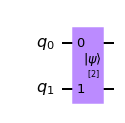

In [18]:
# Az áramkör inicializására is van lehetőség
qc = QuantumCircuit(2)

qc.initialize(2)

qc.draw('mpl')

In [21]:
# Áramkör inicializálás egy állapotvektorral és áramkörök összkapcsolása.

from qiskit.extensions import Initialize
from qiskit.quantum_info import Statevector, random_statevector

state = random_statevector(2)
init_circ = Initialize(state)

qc = QuantumCircuit(1)
qc.append(init_circ, [0])
qc.h(0)
qc.save_statevector()
qc.draw()

┌───────────────────────────────────────────────┐┌───┐ ░ 
q: ┤ Initialize(0.22874+0.943j,-0.068415+0.23183j) ├┤ H ├─░─
   └───────────────────────────────────────────────┘└───┘ ░

### Áramkör futtatása és az eredmény feldolgozás, vizualizálása

In [2]:
# Miután létrehoztuk az áramkört, természetesen szeretnénk használni is. Ebben segítenek a backend-ek, melyek végrehajtják az áramkört.
# Több backend is létezik. Van, amelyik egy ideális, hibamentes kvantumszámítógépet valósít meg, de van olyan is, melyben megtalálható egy zajmodell.
# Mindegyik backend-et az Aer.get_backend() hívással tudunk elérni paraméterként megadva a backend nevét.
from qiskit.providers.aer import Aer

In [3]:
# A legegyszerűbb ilyen backend a statevector_simulator, mellyel az kvantumos állapotvektorát tudjuk nyomonkövetni a végrehajtás során. Azaz itt "nem jön létre" klasszikus adat.
backend = Aer.get_backend("statevector_simulator")

# Egy áramkör futtatása minden backend-nél azonos folyamot. Létrehozunk egy job objektumot, mely magát a szimulációt tartalmazza. Ezt a backend run függvényével tehetjük meg.
# Ez egy aszinkron folyamat, azaz a háttérben elindul és nem blokkolja a főszálat. Az eredményt a result függvénnyel tudjunk lékérni, ami viszont blokkoló hívás.
job = backend.run(qc)
result = job.result() # Blokkoló hívás!

# A statevector_simulator eredményét a result.get_statevector függvénnyel tudjuk kinyerni megadva az áramkört paraméterként.
outputstate = result.get_statevector(qc)
print(outputstate)

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))


In [4]:
# Az állapotvektor kiírására több lehetőség is adott.
from qiskit.visualization import array_to_latex, plot_bloch_multivector

array_to_latex(outputstate) # Latex-es kiírás

<IPython.core.display.Latex object>

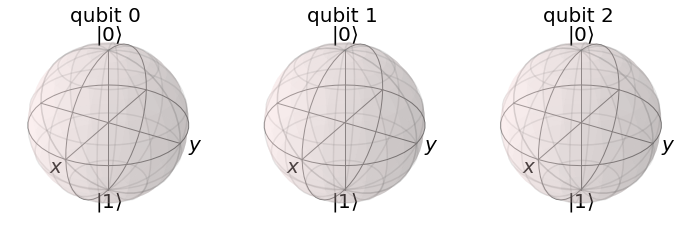

In [5]:
plot_bloch_multivector(outputstate)

In [6]:
# A legtöbb esetben természetesen úgy szeretnénk szimulálni az áramkört, hogy a végén klasszikus információt kapjunk.
# Ebben segít többek között a qasm_simulator és az aer_simulator backend.

# A klasszikus információhoz viszont elengedhetetlen a mérés elhelyezése. Ahhoz, hogy el tudjuk tárolni a klasszikus információt, klasszikus regiszterre van szükség.
# Hozzuk létre újra az áramkört, de most adjuk hozzá 3 klasszikus bitet, melyek a 3 qubit mérési eredményeit fogják felvenni.
# A második paraméter a klasszikus bitek száma.
qc = QuantumCircuit(3,3)
qc.h(0)
qc.cnot(0,1)
qc.cnot(0,2)

# A measure függvény szolgál a mérések elhelyezésére, melynek első paraméter a mérni kívánt qubitek listája, a második a mérési eredményeket tároló klasszikus bitek listája.
qc.measure(range(3), range(3))
qc.draw()

┌───┐             ┌─┐   
q_0: ┤ H ├──■────■─────┤M├───
     └───┘┌─┴─┐  │  ┌─┐└╥┘   
q_1: ─────┤ X ├──┼──┤M├─╫────
          └───┘┌─┴─┐└╥┘ ║ ┌─┐
q_2: ──────────┤ X ├─╫──╫─┤M├
               └───┘ ║  ║ └╥┘
c: 3/════════════════╩══╩══╩═
                     1  0  2

In [7]:
# Próbáljuk ki az aer_simulator-t
backend = Aer.get_backend("aer_simulator")
# Szimuláció esetén megadható, hogy egy job-ban hányszor fusson az áramkört. Erre szolgál a shots paraméter.
result = backend.run(qc, shots=100).result()

# A mérési eredményeket a result.get_counts függvénnyel tudjuk elérni.
counts = result.get_counts()
print(counts)

{'000': 47, '111': 53}


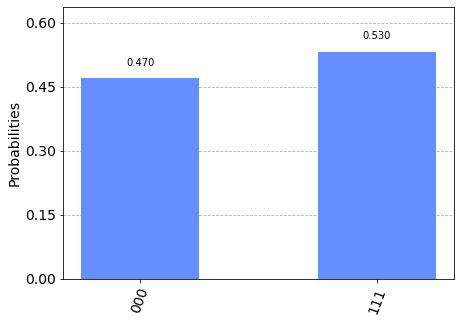

In [8]:
# A mérési eredményeket jobban is tudjuk szemlélteni.
from qiskit.visualization import plot_histogram

plot_histogram(counts)

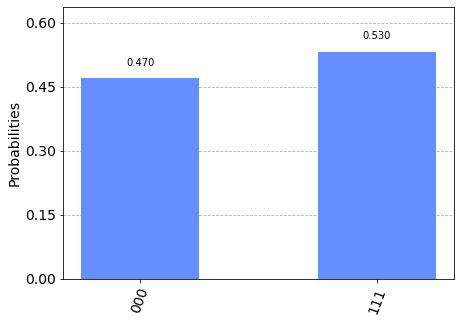

In [9]:
# A másik sokszor használt backend a qasm_simulator.
# Használatakor viszont nem lehet egyszerűen odadni az áramkört, hanem át kell alakítani, hogy a qasm_simulator által is értelmezhető formátumba kerüljün.
# Ebben segít a transpile függvény.
from qiskit import transpile

backend = Aer.get_backend("qasm_simulator")
counts = backend.run(transpile(qc, backend), shots=100).result().get_counts()

plot_histogram(counts)

In [23]:
# Állapotvektor lekérése

backend = Aer.get_backend("aer_simulator")

state = random_statevector(2)
init_circ = Initialize(state)

qc = QuantumCircuit(1)
qc.append(init_circ, [0])
qc.h(0)
qc.save_statevector()


result_state = backend.run(qc).result().get_statevector()
print(result_state)

Statevector([ 0.46506432+0.70305866j, -0.38382102-0.37696834j],
            dims=(2,))


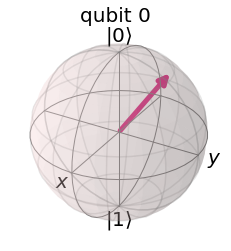

In [24]:
plot_bloch_multivector(result_state)

### 2.1. A Hadamard kapuk vizsgálata

#### 2.1.1. A H kapu egyszeri alkalmazása

Készítsük el a következő áramkört:

![A H kapu egyszeri használata majd mérés](h_gate_simple.png)

Az elvárt eredményt kaptuk?

Mi történik akkor, ha 1000-szer futtatjuk le a szimulációt?

Mi történik, ha kétszer mérünk egymás után?

Azaz módosítsuk a fenti áramkört, hogy a következőt kapjuk:

![Dupla mérés](double_mes.png)

Mit árul ez el a mérés tulajdonságairól?

#### 2.1.2. A H kapu kétszeri alkalmazása

Hozzuk létre a következő áramkört:

![H kapu kétszer egymás után](double_h_gate.png)

Megfelelő eredményt kaptunk? Egybevág a Bloch gömbnél megfigyeltekkel?

#### 2.1.3 Egy nehezítés beiktatása

Módosítsuk a fenti áramkört a következőre:

![Egy lehallgató megjelenése](eve_enters.png)

Változott a korábbi kimenethez képest az tesztelés eredménye?

#### 2.1.4. Tetszőleges állapot előállítása!

Készísünk egy áramkört, amely a $|0\rangle$ állapotból előállítja a $\alpha|0\rangle + \beta e^{i\theta}|1\rangle$ állapotot! Az $\alpha, \beta$ változók pozitív valós számok és $\sqrt{1-\alpha^2} = \beta$. A $\theta$ pedig egy tetszőleg valós szám.

A megoldáshoz haszáljuk fel az következő kapukat:

![Forgatást megvalósító kapuk](rotation_gates.png)

**FONTOS: Az $R_1$ kapu a Qiskit-ben a `P` kapunak feleltethető meg.**

Tipp: Készítsük el először csak a  $\alpha|0\rangle + \beta |0\rangle$ állapotot!

## 3. Az összefonodás és a teleportáció

### A Bell-állapotok

Rövid összefoglaló a Bell-állapotok létrehozásáról:

![A Bell-állapotok előállítása](bell_states.png)

### Bell-állaptok előállítása Qiskit-tel

### 3.1. A teleportáció megvalósítása

A teleportáció áramköre a következő:

![A teleportáció áramköre](teleportation.jpg)

Miért kell a második `CNOT` kapu?

Készítsük el az áramkört egy általunk választott állapotban inicializált első kvantumbittel! Sikeres volt a teleportáció a tesztelés során?

Használjuk fel a korábban elkészített Bell-párokat előállító áramkört és a következő függvényeket:

```python
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)
```

```python
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'
```